### 오토인코더(autoencoder)
- 주성분분석으로 처리하는 일차원 데이터 처리 방식을 딥러닝 방식으로 확장하는 방식으로 비지도학습 방법
- 다차원 입력 데이터를 저차원 부호로 바꾸고 다시 저차원 부호를 처음 입력한 다차원 데이터로 바꾸면서 특징점들을 찾아내는 방식
- 핵심적인 정보만을 남기고 사람이 잘 느끼지 못하거나 둔감한 정보는 손실시키는 압축 방식, 출력값은 입력값의 근사치(노이즈가 있는 데이터가 주어졌을 때 노이즈를 제거하여 원래의 데이터를 재현하는데 사용되는 모델)

- 원래 정보보다 적지만 노이즈를 줄여주는 효과를 긍정적으로 생각할 수도 있음

In [1]:
import torch

EPOCH = 5
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')
DEVICE

device(type='cuda')

In [2]:
# from keras.datasets import mnist
from torchvision import transforms, datasets
import numpy as np

# (x_tr, _), (x_ts, _) = mnist.load_data()
trainset = datasets.FashionMNIST(
    root = 'c:/data/',
    train=True,
    download=True,
    transform = transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2
)

100%|██████████| 26421880/26421880 [00:10<00:00, 2589951.59it/s]


Extracting c:/data/FashionMNIST\raw\train-images-idx3-ubyte.gz to c:/data/FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 104039.63it/s]


Extracting c:/data/FashionMNIST\raw\train-labels-idx1-ubyte.gz to c:/data/FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:02<00:00, 1545218.18it/s]


Extracting c:/data/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to c:/data/FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 5330110.34it/s]

Extracting c:/data/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to c:/data/FashionMNIST\raw



In [3]:
from torch import nn, optim

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # 784 >> 3차원 압축
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12,3),
        )

        # 3 >> 784 복원
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [4]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 0.005)
criterion = nn.MSELoss()

In [5]:
print(autoencoder)
print(optimizer)
print(criterion)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU()
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    weight_decay: 0
)
MSELoss()


In [6]:
view_data = trainset.data[:5].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.
view_data

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [7]:
def train(autoencoder, train_loader):
    autoencoder.train()
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)
        label = label.to(DEVICE)
        encoded, decoded = autoencoder(x)
        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [11]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

[Epoch1]


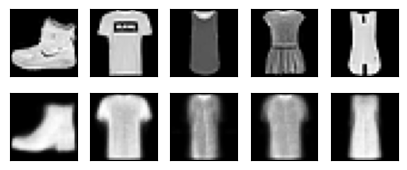

[Epoch2]


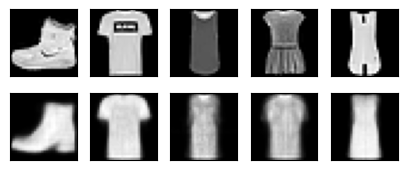

[Epoch3]


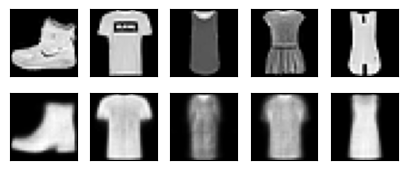

[Epoch4]


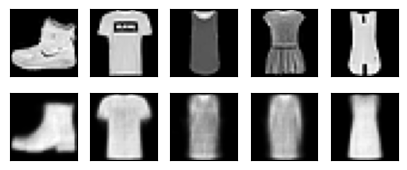

[Epoch5]


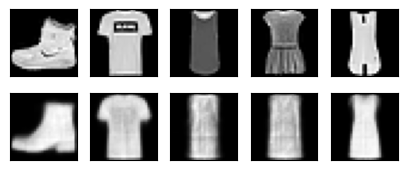

In [12]:
import matplotlib.pyplot as plt
for epoch in range(1, EPOCH+1):
    train(autoencoder, train_loader)

    # 복원이미지
    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)
    f, a = plt.subplots(2, 5, figsize = (5,2))
    print('[Epoch{}]'.format(epoch))
    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i], (28, 28))
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())

    for i in range(5):
        img = np.reshape(decoded_data.to('cpu').data.numpy()[i], (28, 28))
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
    plt.show()

In [13]:
view_data = trainset.data[:200].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.
test_x = view_data.to(DEVICE)
encoded_data, _ = autoencoder(test_x)
encoded_data = encoded_data.to('cpu')
encoded_data.shape

torch.Size([200, 3])

In [16]:

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

print(encoded_data.data)

tensor([[-5.3078e+00,  4.0059e+00,  6.8258e+00],
        [-6.0400e+00, -6.8631e+00, -4.3130e+00],
        [-1.6217e+00, -4.6736e+00,  1.1554e+00],
        [-2.2471e+00, -5.5489e+00,  3.3155e+00],
        [-2.5251e+00, -1.0359e+01,  6.9920e+00],
        [-8.8186e+00, -3.8040e+00, -1.5938e+00],
        [-3.2105e+00,  3.1567e+00, -9.0233e-01],
        [-1.2413e+01, -3.8354e+00, -5.7453e+00],
        [-1.7803e+00, -3.5154e-01,  2.3800e+00],
        [-3.3127e+00,  3.1119e-01,  3.1212e+00],
        [-4.6239e+00, -6.6497e+00, -4.1407e+00],
        [-3.5416e+00, -7.8539e-01,  1.4623e+01],
        [-2.9384e+00,  1.5849e+00, -9.9190e-02],
        [-2.3560e+00,  1.2438e+00, -1.0163e+00],
        [-1.5053e+00,  2.1290e+00, -2.2128e-01],
        [-5.7444e+00,  3.8369e+00,  3.4275e+00],
        [-3.6822e+00, -5.5217e+00, -7.9494e+00],
        [-4.9726e+00, -7.9026e+00, -4.0843e+00],
        [-9.1512e+00, -3.6685e+00, -9.7860e-02],
        [-3.0227e+00, -2.0761e+00,  6.4457e-01],
        [-3.3701e+00

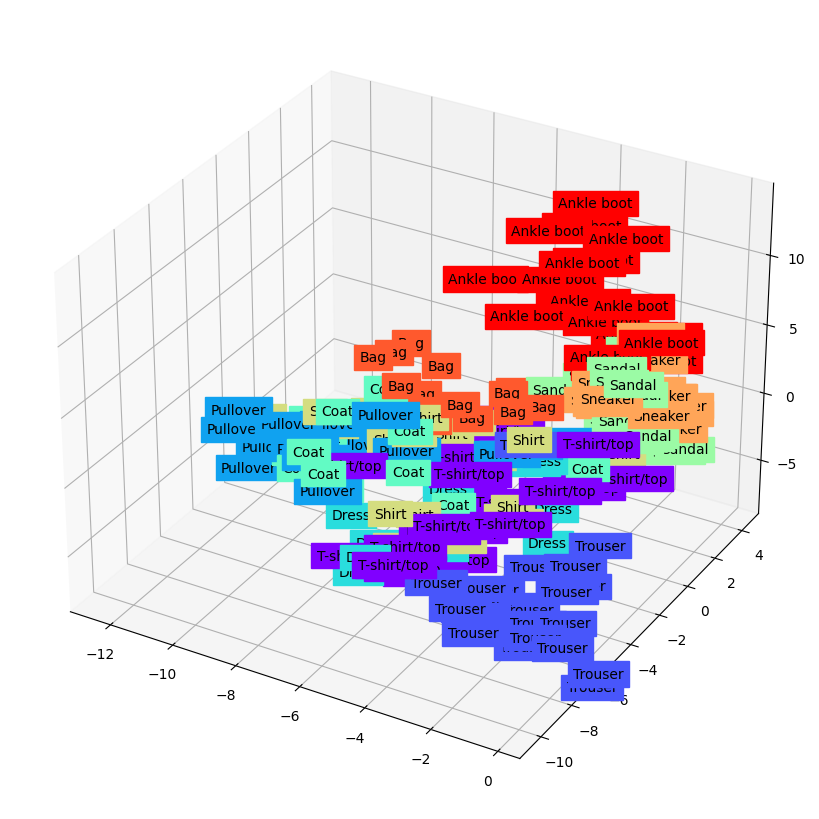

In [17]:
fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

X = encoded_data.data[:, 0].numpy()
Y = encoded_data.data[:, 1].numpy()
Z = encoded_data.data[:, 2].numpy()

labels = trainset.targets[:200].numpy()

for x, y, z, s in zip(X, Y, Z, labels):
    name = CLASSES[s]
    color = cm.rainbow(int(255*s/9))
    ax.text(x, y, z, name, backgroundcolor=color)

ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())
plt.show()